In [ ]:
%load_ext autoreload
%autoreload 2

from src.utils.viz import display_grayscale

In [2]:
# Layer 1 : independent small tracings from a segmentation model
# Already done

In [3]:
# Layer 2 : combine individual small tracings into a large tracing for the original image
# Functionnal, could be improved
# Done : caching / storing tracings in .tif file at some specific location

In [ ]:
from src.tracers.DLTracer import DLTracer
from src.NNs.Unet import UNetModel
model_path = r"./trained_models/topology_aware_models/2025-07-21_AugDataset_thick_axons_connected_loss_0.4_0.0.pth"
tracer = DLTracer(model_path, UNetModel, 128, tracer_name="test_tracer")

In [ ]:
from src.utils.imageio import tif_to_numpy
import numpy as np
# path = r".\data\project_scans\rat301\b516\ipsi_inner\Ipsilesional_ROI.tif"
path = r".\data\project_scans\rat301\b468\contra_inner\Contralesional_ROI.tif"
test_image = tif_to_numpy(path)
test_image = test_image[:, :, :1]

In [6]:
test_image.shape

(1068, 3456, 1)

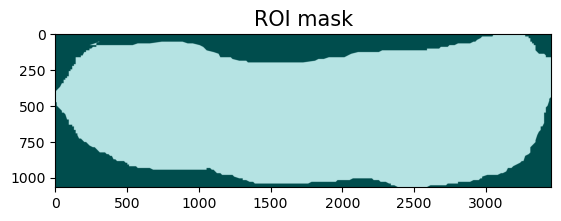

In [ ]:
from src.utils.imageio import generate_image_outer_mask
mask = generate_image_outer_mask(test_image)
display_grayscale(mask, title="ROI mask")

In [8]:
tracing_cache_file = 'test_me/'
trace = tracer.trace(test_image, mask, tracing_cache_folder=tracing_cache_file).squeeze()

In [9]:
trace.shape

(1068, 3456)

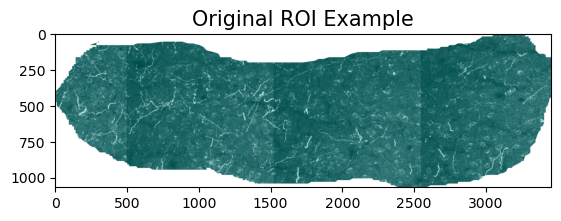

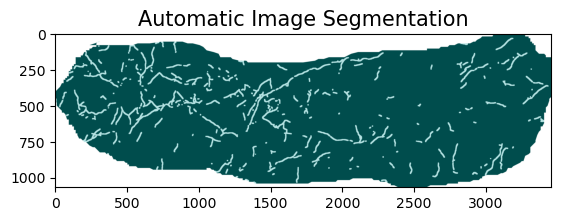

In [ ]:
from src.utils.trace_manips import thicken_trace
from src.imgproc.utils import contrast_img
display_test_image = test_image.copy()
display_test_image = contrast_img(display_test_image, contrast_factor=6)
display_test_image[~mask] = np.nan
display_grayscale(display_test_image, title="Original ROI Example")

display_trace = thicken_trace(trace, 7).astype(np.float32)
display_trace[~mask] = np.nan
display_grayscale(display_trace, title="Automatic Image Segmentation")

In [11]:
# Layer 3 : Get the large tracing and infer features 
# Done. Currently, features infered from small images. (First tile, then maybe something else)

In [ ]:
from src.image_estimators.BaselineMeanExtractors import PopulationMeanExtractor, ImageMeanExtractor
from src.image_estimators.ThresholdDensityExtractor import ThresholdDensityExtractor
from src.image_estimators.TracerExtractor import TraceExtractor

import numpy as np

In [ ]:
from src.utils.traceProps import get_axon_count, get_mean_axon_length, get_trace_density
ground_truth_functions = [get_axon_count, get_mean_axon_length, get_trace_density]
feature_names = ["Fibre Count", "Mean Fibre Length", "Foreground Density"]

extractors = [
    PopulationMeanExtractor(),
    ImageMeanExtractor(feature_extraction_tile_size=64),
    ThresholdDensityExtractor(feature_extraction_tile_size=64, local=True),
    TraceExtractor(tracer, ground_truth_functions=ground_truth_functions, 
                   feature_names=feature_names, feature_extraction_tile_size=64),
    # Add others if needed
]



In [14]:
[ex.is_fittable for ex in extractors]

[True, False, True, False]

In [15]:

# reduce to non-fit ones for testing
extractors = [ex for ex in extractors if not ex.is_fittable]


In [16]:
extractors

Extractor ImageMeanExtractor created features of shape : (1068, 3456, 1)
Showing feature image for feature Image Pixel Mean


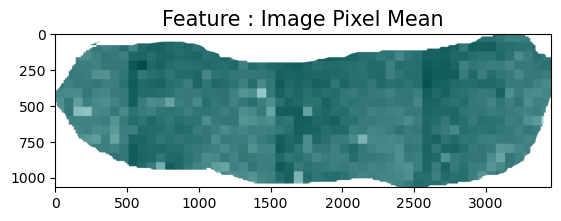

Extractor test_tracerExtractor created features of shape : (1068, 3456, 3)
Showing feature image for feature Fibre Count for test_tracer trace


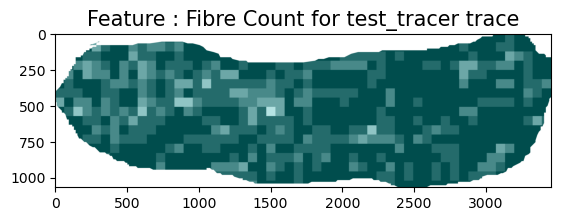

Showing feature image for feature Mean Fibre Length for test_tracer trace


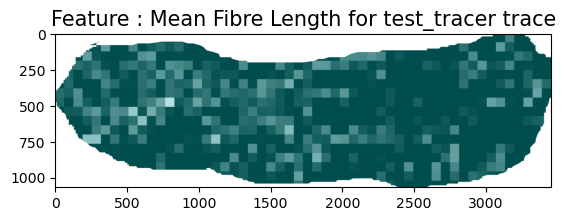

Showing feature image for feature Foreground Density for test_tracer trace


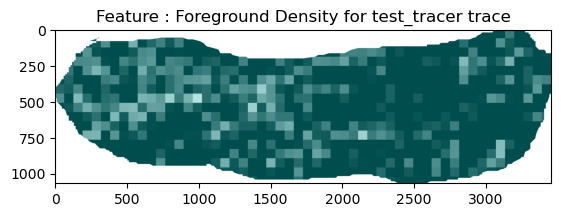

In [17]:
for extractor in extractors:
    features = extractor.extract(test_image, mask, cache_folder="test_me")
        
    print(f"Extractor {extractor.extractor_name} created features of shape : {features.shape}")
    
    for feature_image, feature_name in zip(np.moveaxis(features, 2, 0), extractor.feature_names):
        print(f"Showing feature image for feature {feature_name}")
        display_grayscale(feature_image, title=f"Feature : {feature_name}")

In [18]:
# Layer 4 : Make a features -> properties model that can fit data with input (image, [properties]) pairs.
# Done

In [ ]:
from src.image_estimators.PropertyModel import PropertyModel
from sklearn.linear_model import LinearRegression

cache_path = r'.\data\project_tracing_and_features\test_model'
prop_model = PropertyModel(extractors=extractors, model=LinearRegression(), cache_folder=cache_path)

In [ ]:
from src.evaluation.Trainer import Trainer
dataset_path = r'.\data\tracings\rat301_train'
trainer = Trainer(dataset_path, ground_truth_functions=ground_truth_functions)
trainer.fit_model(prop_model)

In [21]:
image_path = r".\data\project_scans\rat301\b468\contra_inner\\doesntmatter.tif"
properties = prop_model.predict(test_image, mask=mask, tile_size=64, image_path=image_path)

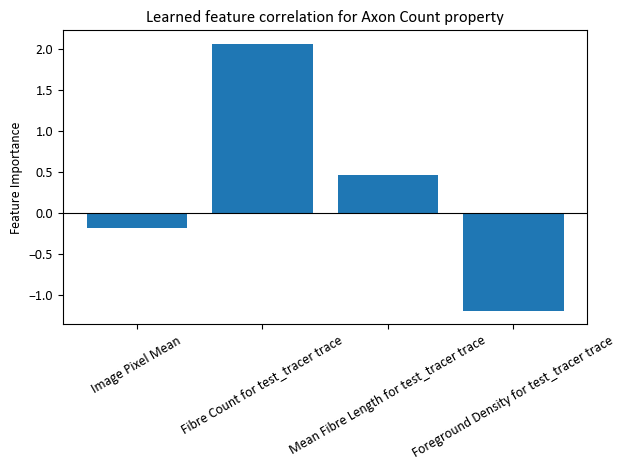

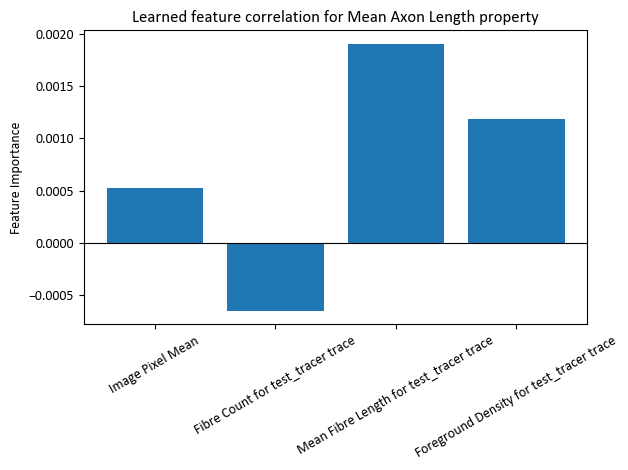

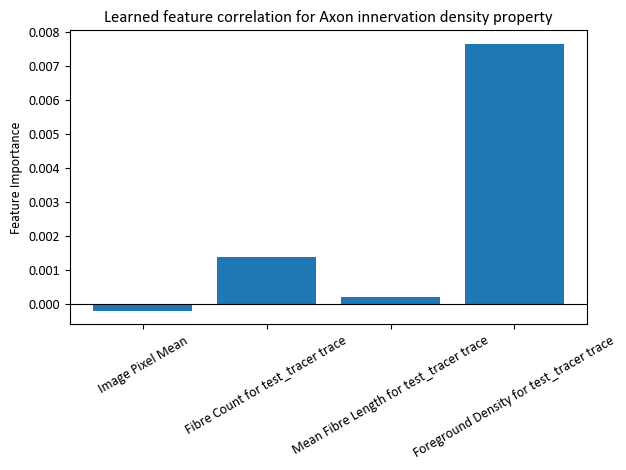

In [22]:
propery_names = ["Axon Count", "Mean Axon Length", "Axon innervation density"]
prop_model.show_feature_weights(propery_names)

Showing feature image for feature property_map


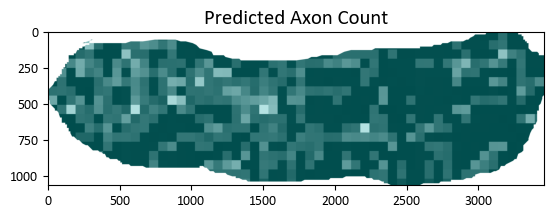

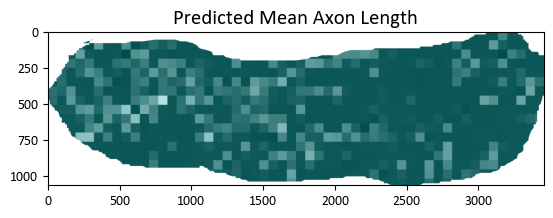

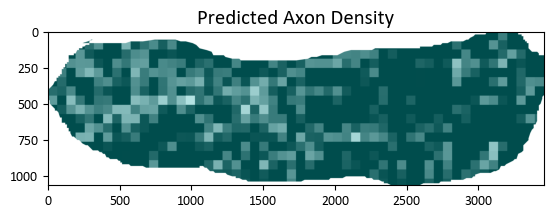

In [23]:
print(f"Showing feature image for feature property_map")
display_grayscale(properties[:,:, 0], title="Predicted Axon Count")
display_grayscale(properties[:,:, 1], title="Predicted Mean Axon Length")
display_grayscale(properties[:,:, 2], title="Predicted Axon Density")

In [ ]:
# Layer 5: Evaluation by first inferring on whole image, then obtaining predictions by cropping features to specific starting point
# Done, not tested

from src.evaluation.RegressionEvaluator import RegressionEvaluator
ground_truth_functions = [get_axon_count, get_mean_axon_length, get_trace_density]
propery_names = ["Axon Count", "Mean Axon Length", "Axon innervation density"]
dataset_path = r'.\data\tracings\rat301_test'
tracings_cache_folder = r'.\data\tracings\project_tracing_and_features'
evaluator = RegressionEvaluator(image_paths=dataset_path, tracings_cache_folder=tracings_cache_folder, 
                                estimated_names=propery_names, ground_truth_functions=ground_truth_functions)


ROI : .\data\project_scans\rat301\b276\contra_inner\th.tif


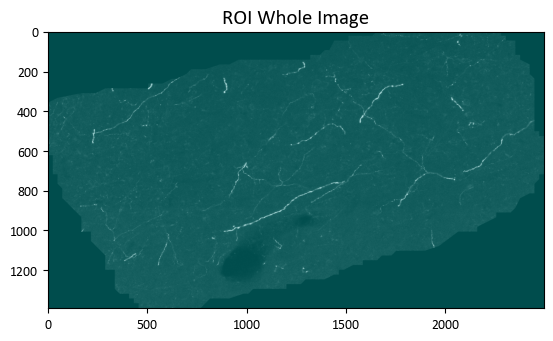

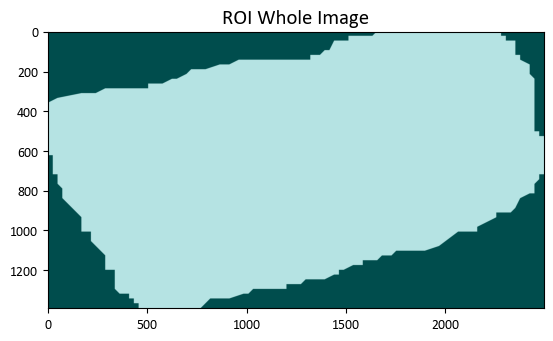

In [25]:
evaluator.display_random_ROIS(n_rois=1)

Real properties : [1.   0.04 0.04], Predicted properties : [1.8  0.02 0.03]
From path : .\data\tracings\rat301_test\img_0017\img.tif


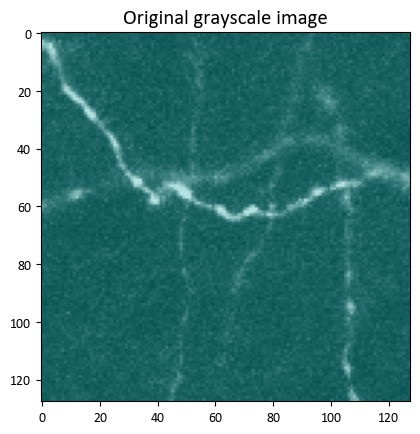

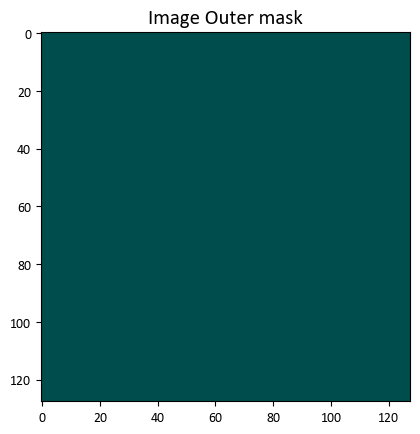

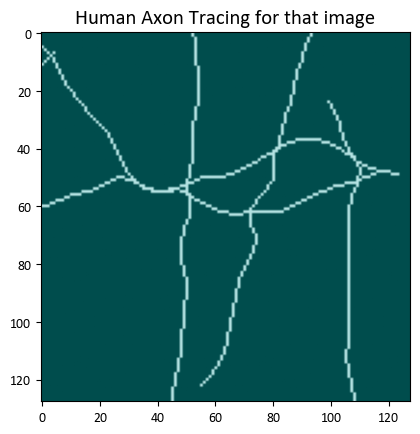

Real properties : [4.   0.   0.02], Predicted properties : [3.7  0.01 0.02]
From path : .\data\tracings\rat301_test\img_0009\img.tif


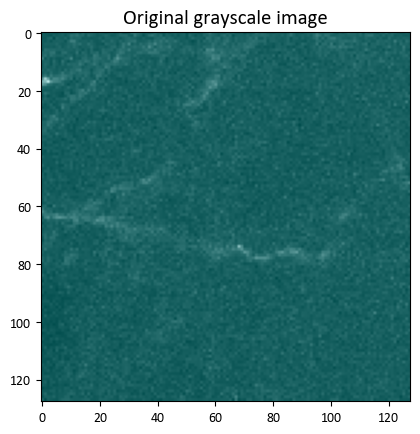

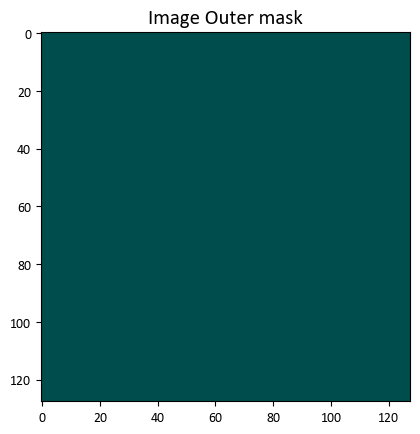

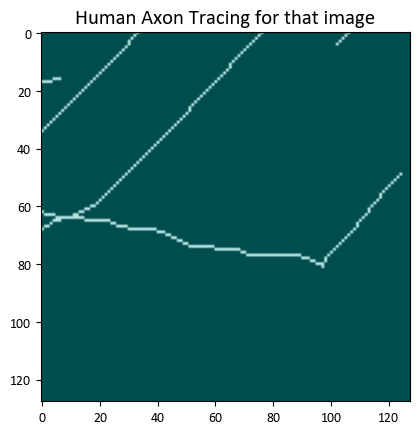

Real properties : [4. 0. 0.], Predicted properties : [1.93 0.   0.  ]
From path : .\data\tracings\rat301_test\img_0075\img.tif


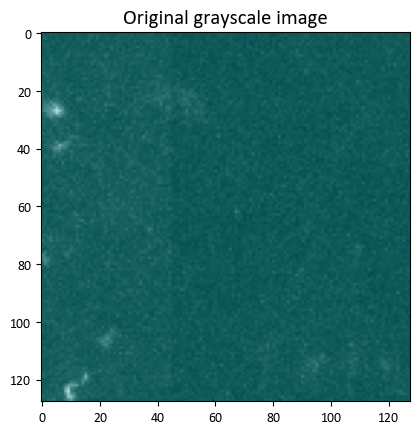

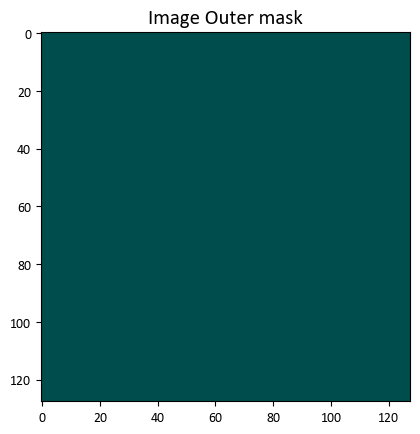

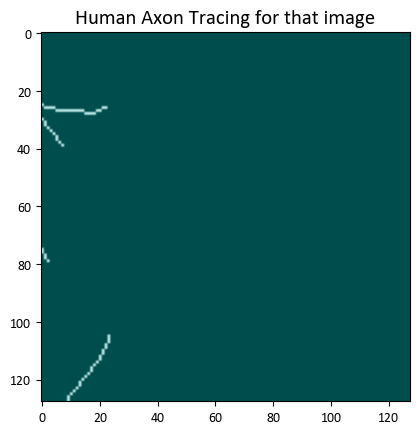

Real properties : [7.   0.01 0.04], Predicted properties : [4.14 0.01 0.04]
From path : .\data\tracings\rat301_test\img_0089\img.tif


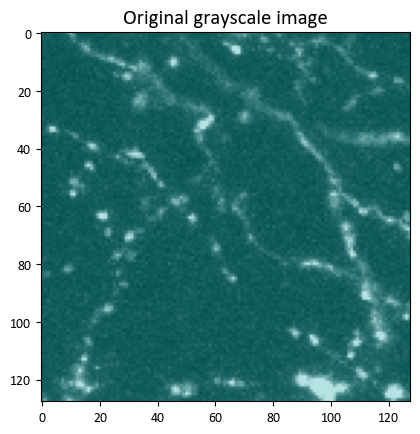

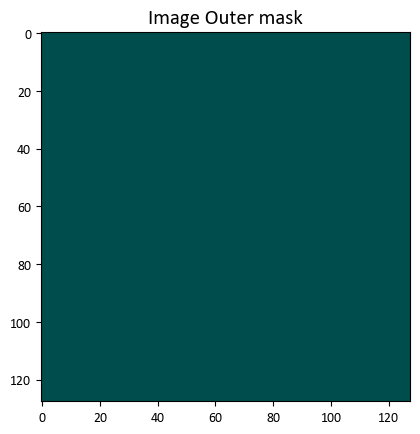

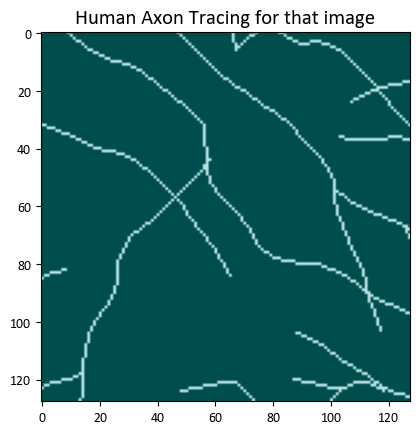

Real properties : [7.   0.   0.03], Predicted properties : [5.24 0.01 0.03]
From path : .\data\tracings\rat301_test\img_0086\img.tif


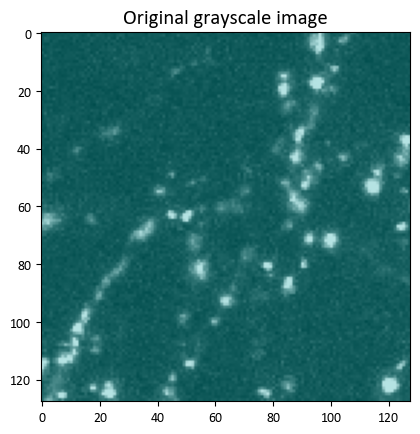

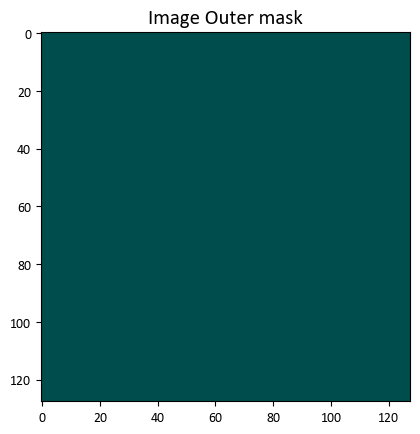

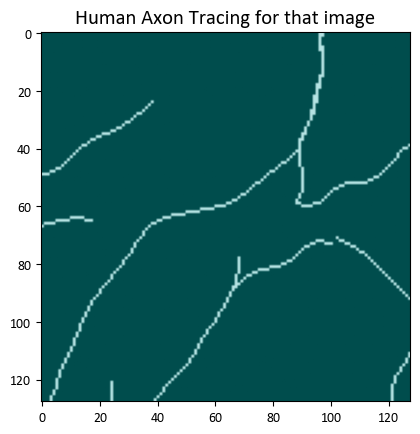

Real properties : [2. 0. 0.], Predicted properties : [0.93 0.   0.  ]
From path : .\data\tracings\rat301_test\img_0025\img.tif


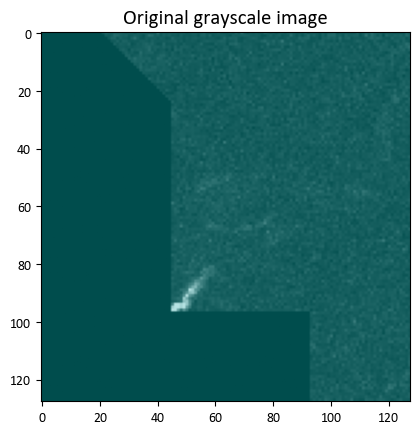

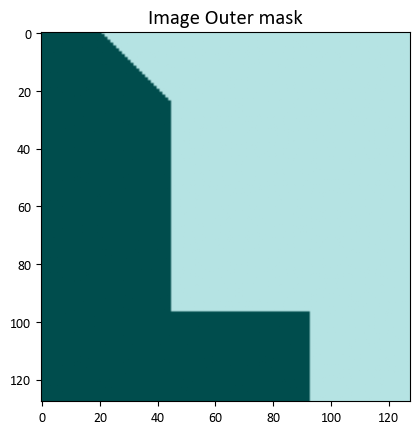

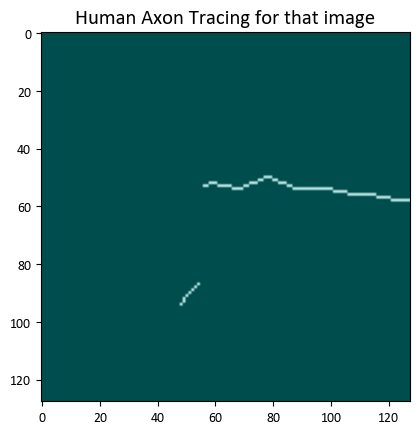

Real properties : [2.   0.01 0.02], Predicted properties : [3.11 0.01 0.02]
From path : .\data\tracings\rat301_test\img_0100\img.tif


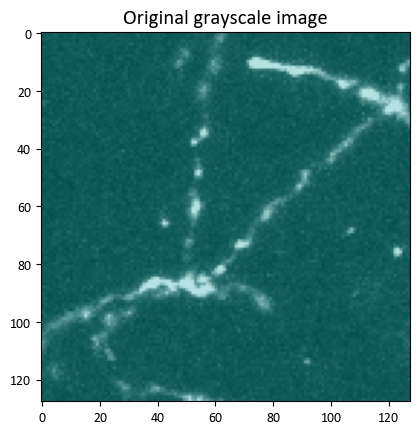

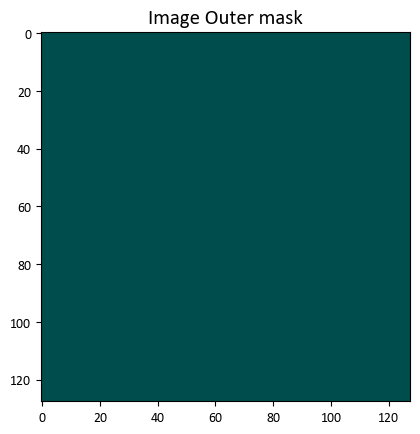

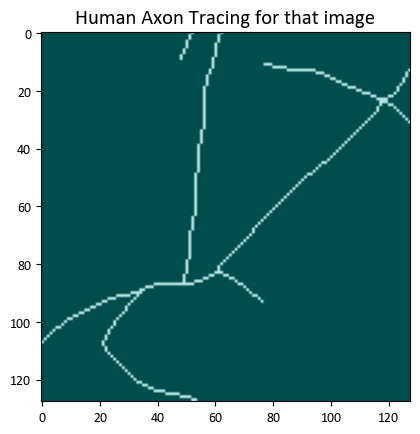

Real properties : [0. 0. 0.], Predicted properties : [0.92 0.   0.  ]
From path : .\data\tracings\rat301_test\img_0002\img.tif


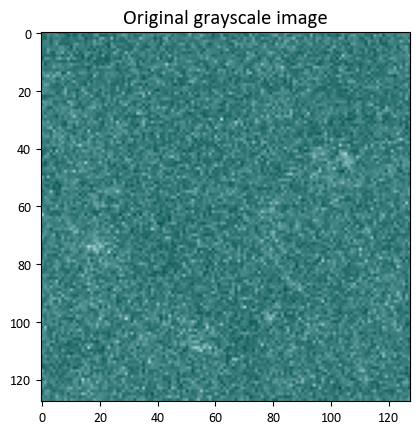

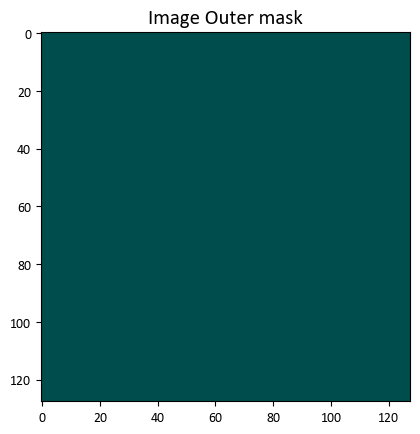

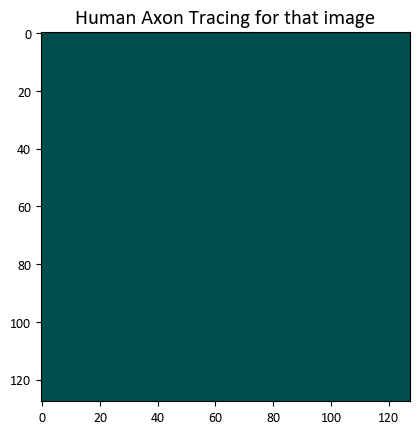

Real properties : [4.   0.01 0.02], Predicted properties : [4.75 0.01 0.02]
From path : .\data\tracings\rat301_test\img_0051\img.tif


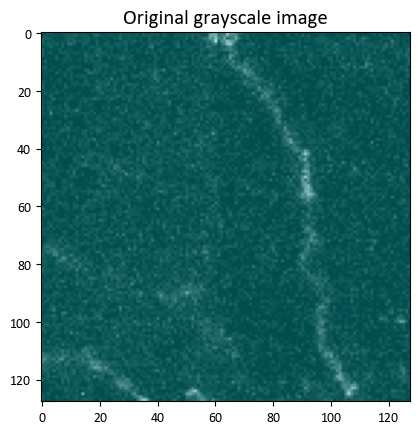

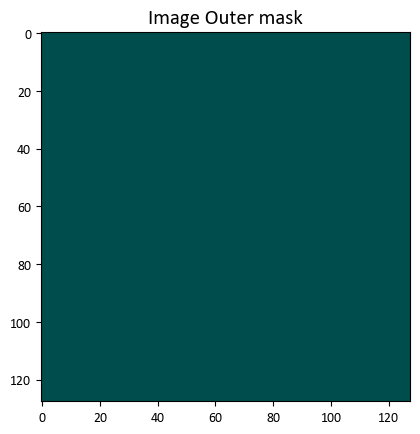

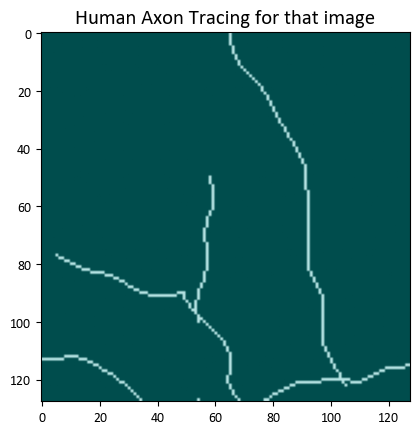

Real properties : [0. 0. 0.], Predicted properties : [1.12 0.   0.  ]
From path : .\data\tracings\rat301_test\img_0033\img.tif


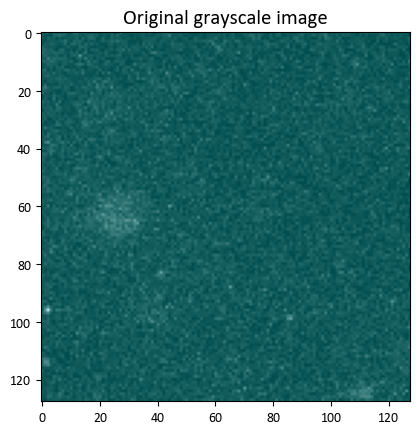

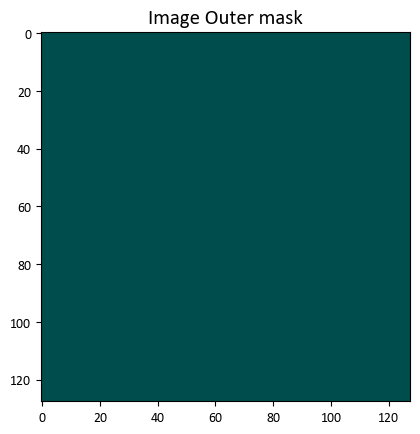

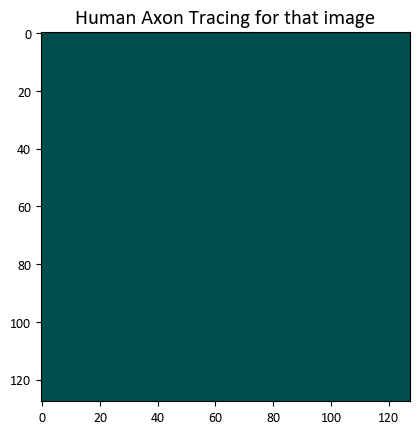

In [26]:
evaluator.display_random_images_and_predictions(prop_model, n_images=10)

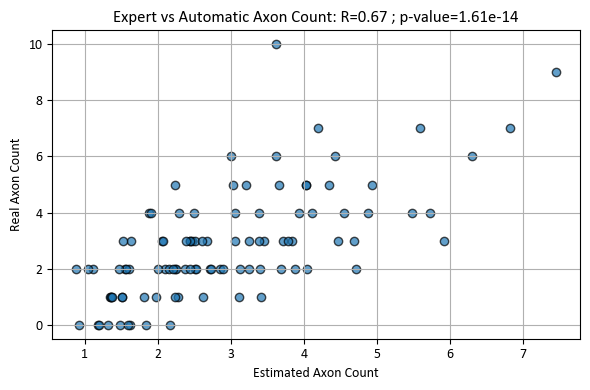

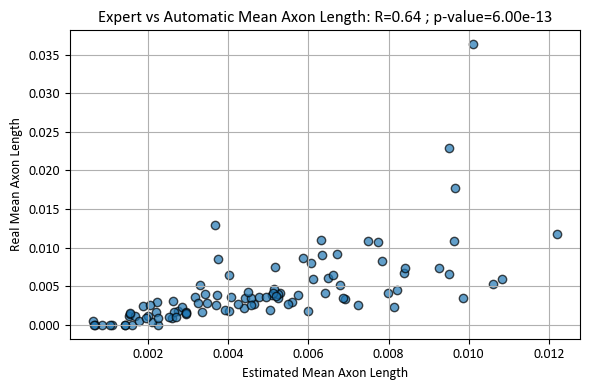

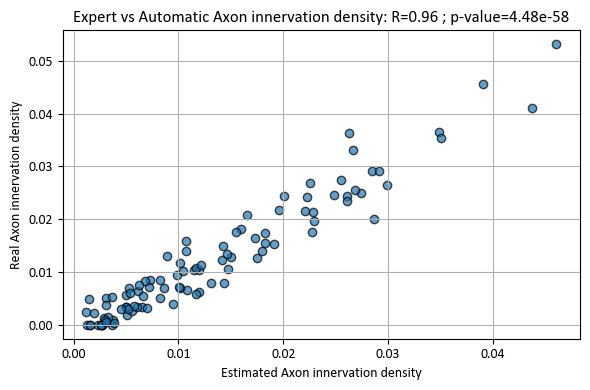

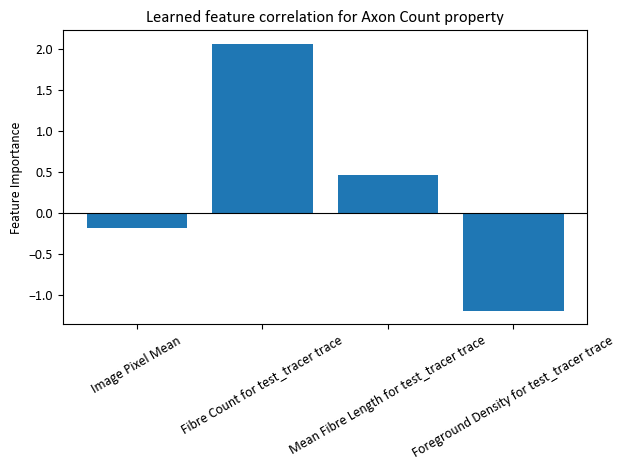

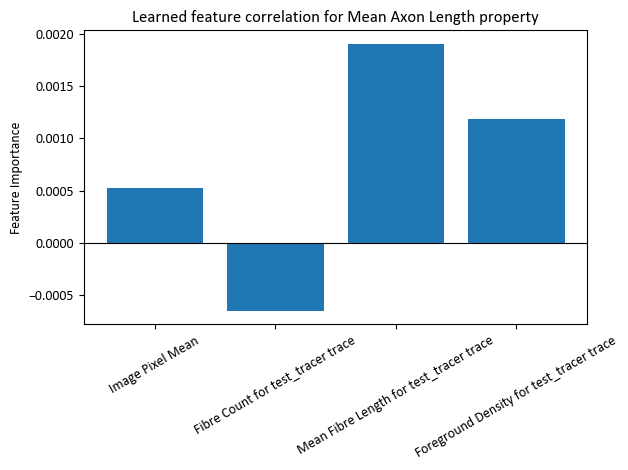

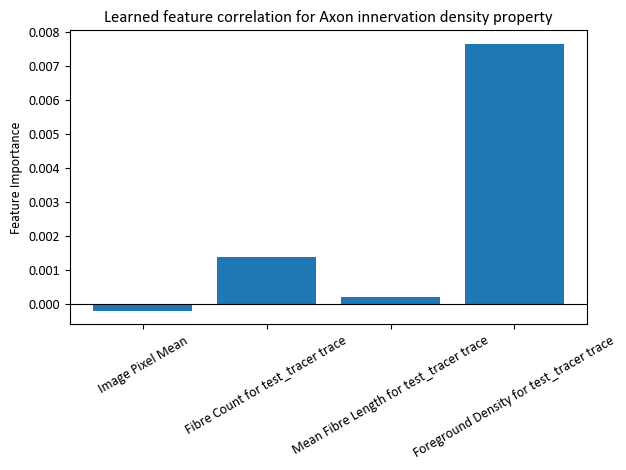

(array([[1.3599099 , 0.00273665, 0.00512273],
        [0.9159755 , 0.00142386, 0.00124104],
        [0.8826261 , 0.00151775, 0.00120417],
        [2.5024195 , 0.00370444, 0.00823663],
        [2.0925007 , 0.00442141, 0.0086308 ],
        [1.9804826 , 0.00400651, 0.00616995],
        [1.8158263 , 0.00375221, 0.00731986],
        [1.4868041 , 0.00160693, 0.00232142],
        [5.724787  , 0.0037102 , 0.01824018],
        [4.4230027 , 0.00528381, 0.02009944],
        [2.2316031 , 0.00505149, 0.00986424],
        [5.4751782 , 0.00509299, 0.01911513],
        [4.344798  , 0.00723115, 0.01749957],
        [1.5058414 , 0.00260275, 0.00371317],
        [4.0225706 , 0.00691416, 0.01734248],
        [1.3450695 , 0.00463199, 0.00559925],
        [3.1086535 , 0.01010615, 0.02627498],
        [3.388934  , 0.00456265, 0.01068715],
        [2.620186  , 0.00153559, 0.00292241],
        [2.4366226 , 0.00285157, 0.00531561],
        [1.5529914 , 0.00347011, 0.0049764 ],
        [1.1115061 , 0.00167473, 0

In [27]:
evaluator.evaluate_ROIs(prop_model, display_fitness=True)